In [2]:
img_path = "input.jpg"

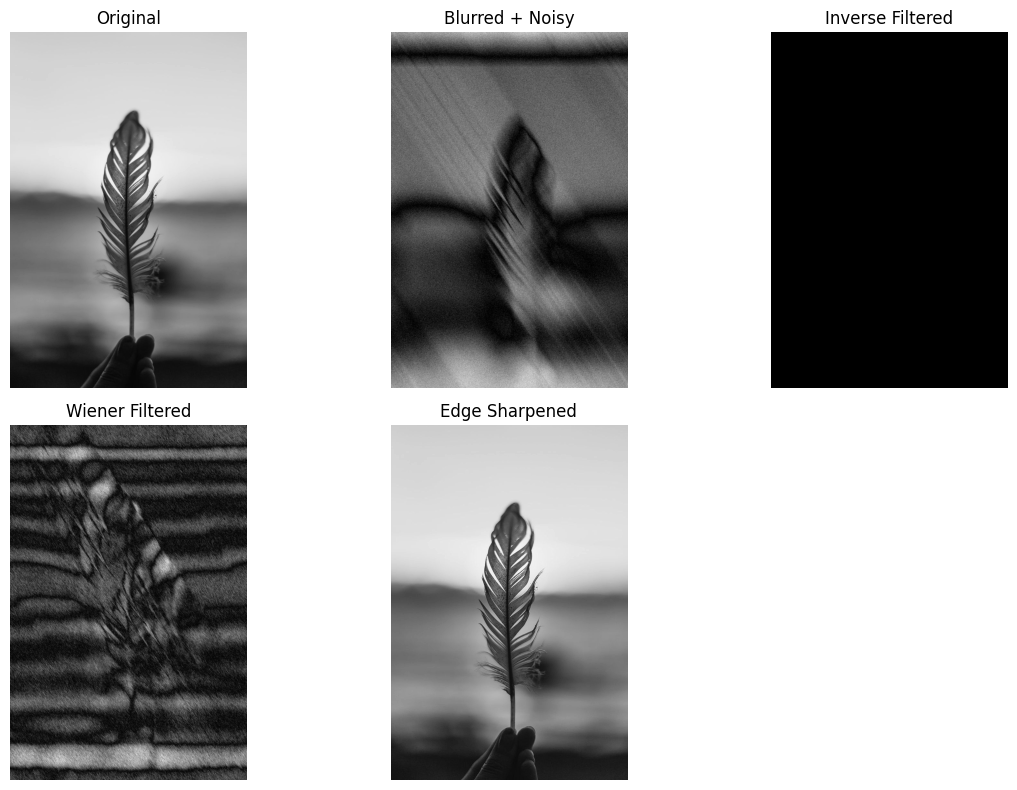

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read grayscale image
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Image not found. Please check the path.")

# Step 2: Simulate motion blur (degradation function)
def motion_blur_psf(shape, a=0.1, b=0.1, T=1):
    """Creates motion blur transfer function H(u,v)"""
    M, N = shape
    u, v = np.meshgrid(np.arange(N), np.arange(M))
    u = u - N/2
    v = v - M/2
    pi = np.pi
    eps = 1e-8
    H = (T * np.sin(pi*(u*a + v*b)) * np.exp(-1j*pi*(u*a + v*b))) / (pi*(u*a + v*b) + eps)
    return np.fft.fftshift(H)

# Create degradation function
H = motion_blur_psf(image.shape)

# Step 3: Blur and add noise to the image
f = np.fft.fft2(image)
blurred = np.fft.ifft2(f * H)
blurred = np.abs(blurred)
noise = np.random.normal(0, 10, image.shape)
noisy = np.clip(blurred + noise, 0, 255).astype(np.uint8)

# Step 4: Inverse Filtering
H_mag = np.abs(H)
eps = 1e-3  # prevent division by zero
inv_filtered = np.fft.ifft2(np.fft.fft2(noisy) / (H + eps))
inv_filtered = np.abs(inv_filtered)
inv_filtered = np.clip(inv_filtered, 0, 255).astype(np.uint8)

# Step 5: Wiener Filtering
K = 0.01  # noise-to-signal ratio (adjust experimentally)
H_conj = np.conj(H)
wiener_filter = (H_conj / (H_mag**2 + K))
wiener_result = np.fft.ifft2(np.fft.fft2(noisy) * wiener_filter)
wiener_result = np.abs(wiener_result)
wiener_result = np.clip(wiener_result, 0, 255).astype(np.uint8)

# Step 6: Edge Sharpening (Spatial Domain)
# Using Laplacian sharpening
laplacian = cv2.Laplacian(image, cv2.CV_64F)
sharp = cv2.convertScaleAbs(image - 0.5 * laplacian)

# Step 7: Display Results
titles = ['Original', 'Blurred + Noisy', 'Inverse Filtered', 'Wiener Filtered', 'Edge Sharpened']
images = [image, noisy, inv_filtered, wiener_result, sharp]

plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


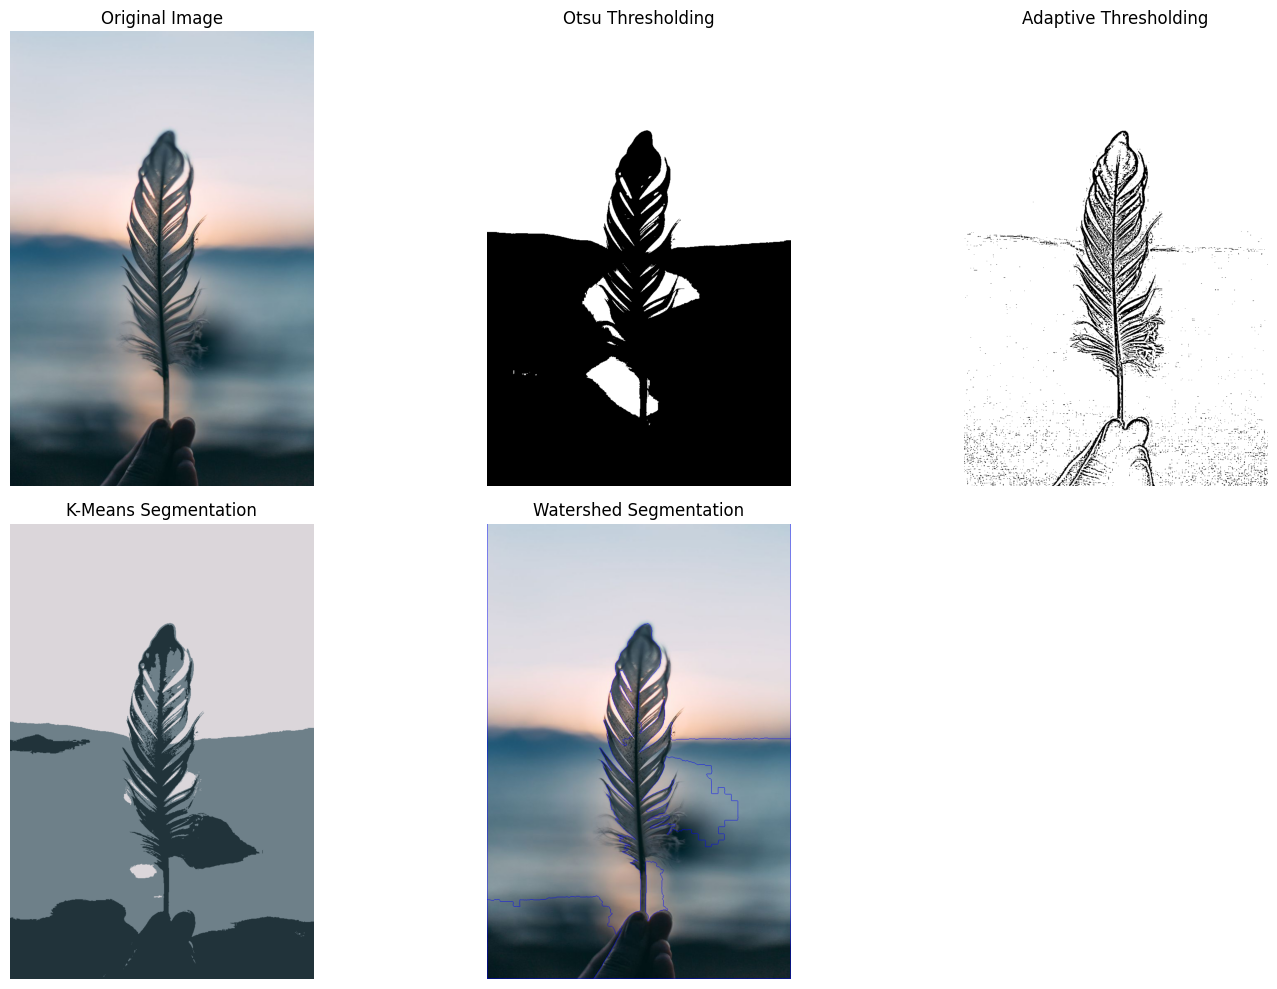

In [4]:
# image segmentation
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read and preprocess the image
image = cv2.imread(img_path)
if image is None:
    raise ValueError("Image not found. Please check the path.")

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 2: Global Thresholding (Otsu's Method)
# Automatically calculates optimal threshold value
_, otsu_thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Step 3: Adaptive Thresholding
adaptive_thresh = cv2.adaptiveThreshold(
    gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY, 11, 2
)

# Step 4: K-Means Clustering Segmentation
Z = image.reshape((-1, 3))
Z = np.float32(Z)
# Define criteria and number of clusters (K)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3  # number of segments
_, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
segmented_img = centers[labels.flatten()]
segmented_img = segmented_img.reshape(image.shape)

# Step 5: Watershed Segmentation
# Convert to gray and apply threshold
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
# Noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
# Sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)
# Sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
# Unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
# Marker labeling
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0
# Apply watershed
image_watershed = image.copy()
cv2.watershed(image_watershed, markers)
image_watershed[markers == -1] = [255, 0, 0]  # boundaries in red

# Step 6: Display results
titles = [
    'Original Image',
    'Otsu Thresholding',
    'Adaptive Thresholding',
    'K-Means Segmentation',
    'Watershed Segmentation'
]
images = [
    cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    otsu_thresh,
    adaptive_thresh,
    cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB),
    cv2.cvtColor(image_watershed, cv2.COLOR_BGR2RGB)
]

plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()
